# Data And Imports

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

     |████████████████████████████████| 2.6MB 5.8MB/s 


In [ ]:
!pip install -q tf-models-official
!pip install transformers

     |████████████████████████████████| 849kB 6.1MB/s 
     |████████████████████████████████| 36.7MB 86kB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 1.1MB 56.2MB/s 
     |████████████████████████████████| 174kB 62.4MB/s 
     |████████████████████████████████| 358kB 59.2MB/s 
     |████████████████████████████████| 1.4MB 4.2MB/s 
     |████████████████████████████████| 2.9MB 54.1MB/s 
     |████████████████████████████████| 890kB 41.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=76859e10735729ce9e245444131332734977e02c0264e9993f049022e04a91a8
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Imports

In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer
import pandas as pd 
from transformers import BertTokenizer, TFBertModel, BertConfig
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
tf.__version__

'2.3.0'

Loading the train and test data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/work/NLP/DEEP_NLP/BERT/train.csv')
train = train.dropna()
train.shape

(27480, 4)

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/work/NLP/DEEP_NLP/BERT/test.csv')
test = test.dropna()
test.shape

(3534, 3)

In [ ]:
# for Debuging, traing on small data
train = train.loc[:5000]
test = test.loc[:1000]

In [ ]:
train.isnull().sum().sum()

0

In [ ]:
train = train.reset_index().drop(columns='index')

# Preprocessing

convert the text to ids, 

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
positive_id = tokenizer("positive")['input_ids'][1]
neutral_id = tokenizer("neutral")['input_ids'][1]
negative_id = tokenizer("negative")['input_ids'][1]


In [ ]:
MAX_LEN = 192
sentiment_id = {'positive': positive_id, 'negative': neutral_id, 'neutral': negative_id}

In [ ]:
def find_start_end_ids_selected_text(text, selected_text):
    start_tokens = [0] * MAX_LEN
    end_tokens = [0] * MAX_LEN

    # FIND OVERLAP
    text1 = " "+" ".join(text)
    text2 = " ".join(selected_text)
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer(text1) 
    enc = enc['input_ids'][1:-1]
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc:
        w = tokenizer.convert_ids_to_tokens([t])
        w=w[0]
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    if len(toks)>0:
        start_tokens[toks[0]+1] = 1
        end_tokens[toks[-1]+1] = 1

    return start_tokens, end_tokens

In [ ]:
input_ids = []
attention_mask = []
token_type_ids = []
start_tokens = []
end_tokens = []

for i in range(train.shape[0]):
    encoded = tokenizer.encode_plus(
      train.loc[i,'sentiment'],
      train.loc[i,'text'],
      add_special_tokens=True,
      max_length=MAX_LEN,
      padding='max_length',
      pad_to_max_length=True,
      return_token_type_ids=True,
      return_attention_mask=True
    )

    input_ids.append(encoded['input_ids'])
    attention_mask.append(encoded['attention_mask'])
    token_type_ids.append(encoded['token_type_ids'])

    # find start token and end token of 'selected text'
    selected_start_token, selected_end_token = find_start_end_ids_selected_text(train.loc[i,'text'], train.loc[i,'selected_text'])
    start_tokens.append(selected_start_token)
    end_tokens.append(selected_end_token)

# convert list of list to numpy 2d array
input_ids = np.array(input_ids, dtype='int32')
attention_mask = np.array(attention_mask, dtype='int32')
token_type_ids = np.array(token_type_ids, dtype='int32')
start_tokens = np.array(start_tokens, dtype='int32')
end_tokens = np.array(end_tokens, dtype='int32')



/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
assert input_ids.shape == attention_mask.shape == token_type_ids.shape == start_tokens.shape == end_tokens.shape

prepare test data

In [ ]:
test = test.reset_index().drop(columns='index')

In [ ]:
input_ids_t = []
attention_mask_t = []
token_type_ids_t = []

for i in range(train.shape[0]):
    encoded = tokenizer.encode_plus(
      train.loc[i,'sentiment'],
      train.loc[i,'text'],
      add_special_tokens=True,
      max_length=MAX_LEN,
      padding='max_length',
      pad_to_max_length=True,
      return_token_type_ids=True,
      return_attention_mask=True
    )

    input_ids_t.append(encoded['input_ids'])
    attention_mask_t.append(encoded['attention_mask'])
    token_type_ids_t.append(encoded['token_type_ids'])

# convert list of list to numpy 2d array
input_ids_t = np.array(input_ids_t, dtype='int32')
attention_mask_t = np.array(attention_mask_t, dtype='int32')
token_type_ids_t = np.array(token_type_ids_t, dtype='int32')



Define function the create validation dataset

In [ ]:
def split_to_train_and_validation(val_ratio, input_ids, attention_mask, token_type_ids, start_tokens, end_tokens):
    val_size = int(val_ratio*input_ids.shape[0])

    train_dict = dict()
    val_dict = dict()

    train_dict["input_ids"] = input_ids[:-val_size]
    train_dict["attention_mask"] = attention_mask[:-val_size]
    train_dict["token_type_ids"] = token_type_ids[:-val_size]
    train_dict["start_tokens"] = start_tokens[:-val_size]
    train_dict["end_tokens"] = end_tokens[:-val_size]

    val_dict["input_ids"] = input_ids[-val_size:]
    val_dict["attention_mask"] = attention_mask[-val_size:]
    val_dict["token_type_ids"] = token_type_ids[-val_size:]
    val_dict["start_tokens"] = start_tokens[-val_size:]
    val_dict["end_tokens"] = end_tokens[-val_size:]

    return train_dict, val_dict


In [ ]:
train_dict, val_dict = split_to_train_and_validation(0.25, input_ids, attention_mask, token_type_ids, start_tokens, end_tokens)

# Modeling

In [ ]:
configuration = BertConfig()  # default parameters and configuration for BERT

In [ ]:
def build_qa_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32, name="input_word_ids")
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32, name="input_mask")
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32, name="segment_ids")

    bert_encoder = TFBertModel.from_pretrained("bert-base-uncased",config=configuration )
    x = bert_encoder(
        ids, attention_mask=att, token_type_ids=tok)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    
    return tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])

In [ ]:
qa_model = build_qa_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


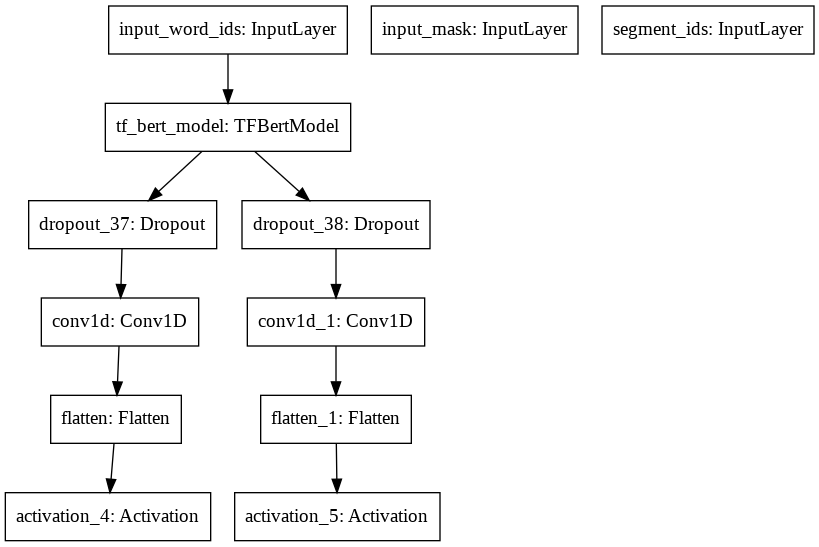

In [ ]:
tf.keras.utils.plot_model(qa_model)

Model training

In [ ]:
epochs = 4
batch_size = 32
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

Loading the BERT model and training

In [ ]:
qa_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:

history = qa_model.fit(x=[train_dict.get("input_ids"), train_dict.get("attention_mask"), train_dict.get("token_type_ids")],
                       y=[train_dict.get("start_tokens"),train_dict.get("end_tokens")],
                       validation_data = ([val_dict.get("input_ids"), val_dict.get("attention_mask"), val_dict.get("token_type_ids")], [val_dict.get("start_tokens"),val_dict.get("end_tokens")]),
                       epochs=epochs,
                       batch_size=batch_size)


118/118 [==============================] - 94s 796ms/step - loss: 5.7640 - activation_4_loss: 1.9125 - activation_5_loss: 3.8516 - val_loss: 4.9994 - val_activation_4_loss: 1.6565 - val_activation_5_loss: 3.3430


# Evaluate The Model

 predict

In [ ]:
preds = qa_model.predict([input_ids,attention_mask,token_type_ids])

In [ ]:
pred_start = preds[0]
pred_end = preds[1]

for k in range(train.shape[0]):
    a = np.argmax(pred_start[k])
    b = np.argmax(pred_end[k])

    if a>b: 
        st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
    else:
        text1 = " "+" ".join(train.loc[k,'text'].split())
        enc = tokenizer(text1)
        enc = enc['input_ids']   
        st = tokenizer.convert_ids_to_tokens(enc[a-1:b])          

        train.loc[k, "pred_selected_text"] = " ".join(st)

In [ ]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


def jaccard_score(selected_text, pred_selected_text):
    all_scores = []

    for x, y in zip(selected_text, pred_selected_text):
        temp_score = jaccard_similarity(x,  y)
        all_scores.append(temp_score)

    return sum(all_scores) / len(all_scores)
    




In [ ]:
jaccard_score(train["selected_text"],train["pred_selected_text"])

0.11171025572478187

In [ ]:
#TODO:
# checking the train and validation separately.

Plot the accuracy and loss over time

In [ ]:
history_dict = history.history
print(history_dict.keys())


dict_keys(['loss', 'activation_4_loss', 'activation_5_loss'])


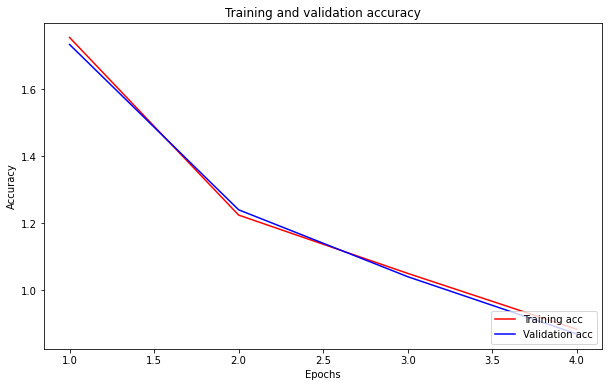

In [ ]:

acc = history_dict['activation_4_loss']
val_acc = history_dict['activation_5_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')